<a href="https://colab.research.google.com/github/kurshid1991/Breastcancer_ML-modelling/blob/main/CNN_breakHisv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


In [3]:
import os
import pandas as pd

# Base directory for your images on Google Drive
base_dir = '/content/drive/MyDrive/images'

# List to hold the data
data = []

# Recursively walk through all folders
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            full_path = os.path.join(root, file).replace('\\', '/')
            parts = full_path.replace(base_dir, '').strip('/').split('/')

            # Extract label and subtype from the folder hierarchy
            label = parts[1] if len(parts) > 1 else 'unknown'  # Magnification (e.g., 100X)
            subtype = parts[2] if len(parts) > 2 else 'unknown'  # Tumor subtype

            # Ensure subtype is one of the valid 8 subtypes
            valid_subtypes = ['DC', 'F', 'MC', 'LC', 'TA', 'PC', 'PT', 'A']
            if subtype not in valid_subtypes:
                continue  # Skip if the subtype is invalid

            # Append data
            data.append({
                'filepath': full_path,
                'label': label,
                'subtype': subtype
            })

# Convert the data to a DataFrame
df_summary = pd.DataFrame(data)

# Save the summary CSV file
summary_csv_path = '/content/drive/MyDrive/summary_clean.csv'
df_summary.to_csv(summary_csv_path, index=False)

print(f"✅ CSV created with {len(df_summary)} image entries: {summary_csv_path}")
print(df_summary.head())


✅ CSV created with 7914 image entries: /content/drive/MyDrive/summary_clean.csv
                                            filepath      label subtype
0  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
1  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
2  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
3  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
4  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC


In [4]:
import pandas as pd

# Load the CSV
df = pd.read_csv('/content/drive/MyDrive/summary_clean.csv')

# Basic info
print("🔍 Basic Info:")
print(df.info())

# Preview the data
print("\n📋 Head of Data:")
print(df.head())

# Check for missing values
print("\n❗ Missing Values:")
print(df.isnull().sum())


🔍 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7914 entries, 0 to 7913
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  7914 non-null   object
 1   label     7914 non-null   object
 2   subtype   7914 non-null   object
dtypes: object(3)
memory usage: 185.6+ KB
None

📋 Head of Data:
                                            filepath      label subtype
0  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
1  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
2  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
3  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
4  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC

❗ Missing Values:
filepath    0
label       0
subtype     0
dtype: int64


In [5]:
# Count of images by label (e.g., 100X, 200X, 400X)
print("\n🔢 Images by Magnification (label):")
print(df['label'].value_counts())

# Count of images by subtype
print("\n🔢 Images by Subtype:")
print(df['subtype'].value_counts())



🔢 Images by Magnification (label):
label
malignant    5434
benign       2480
Name: count, dtype: int64

🔢 Images by Subtype:
subtype
DC    3451
F     1014
MC     792
LC     626
TA     569
PC     565
PT     453
A      444
Name: count, dtype: int64


In [6]:
# Grouped count
grouped = df.groupby(['label', 'subtype']).size().reset_index(name='count')
print("\n📊 Count by Magnification and Subtype:")
print(grouped)



📊 Count by Magnification and Subtype:
       label subtype  count
0     benign       A    444
1     benign       F   1014
2     benign      PT    453
3     benign      TA    569
4  malignant      DC   3451
5  malignant      LC    626
6  malignant      MC    792
7  malignant      PC    565


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


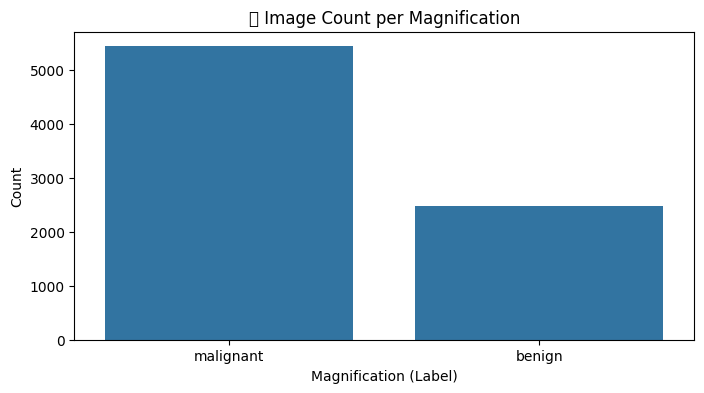

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


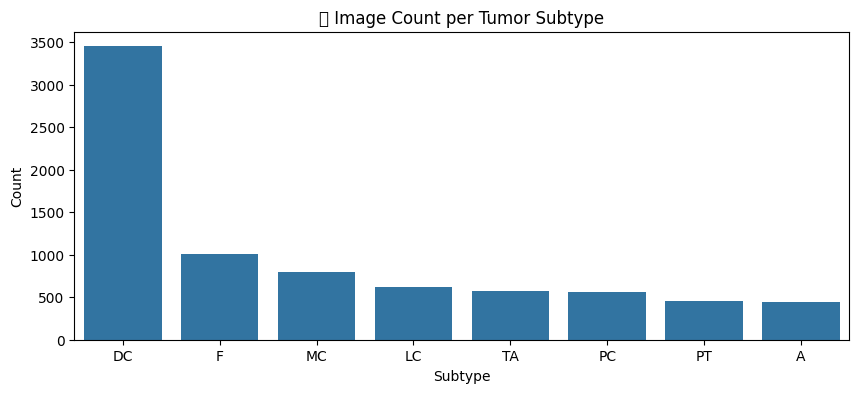

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Barplot: Images per magnification (label)
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('🧪 Image Count per Magnification')
plt.xlabel('Magnification (Label)')
plt.ylabel('Count')
plt.show()

# Barplot: Images per subtype
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='subtype', order=df['subtype'].value_counts().index)
plt.title('🧬 Image Count per Tumor Subtype')
plt.xlabel('Subtype')
plt.ylabel('Count')
plt.show()



In [8]:
cd '/content/drive/MyDrive/images'

/content/drive/MyDrive/images


In [9]:
import os
import numpy as np
from PIL import Image
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

# Parameters
base_dir = '/content/drive/MyDrive/images'  # <-- Change if needed
image_size = (224, 224)
max_images_per_subtype = 444
valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
valid_subtypes = ['DC', 'F', 'MC', 'LC', 'TA', 'PC', 'PT', 'A']

print("🚀 Starting image collection...")
print(f"📁 Base directory: {base_dir}")
print(f"✅ Target size: {image_size}")
print(f"🎯 Max images per subtype: {max_images_per_subtype}")
print(f"🔍 Valid subtypes: {valid_subtypes}")
print(f"🖼️ Valid extensions: {valid_extensions}")

# Initialize storage
X = []
y = []
subtype_counter = defaultdict(int)

# Traverse folders
for root, dirs, files in tqdm(os.walk(base_dir), desc="🗂️ Walking through directories"):
    for file in files:
        if file.lower().endswith(valid_extensions):
            filepath = os.path.join(root, file)

            # Extract subtype from folder name
            parts = filepath.replace(base_dir, '').strip('/').split('/')
            subtype = parts[-2] if len(parts) >= 2 else None

            if subtype in valid_subtypes:
                if subtype_counter[subtype] < max_images_per_subtype:
                    try:
                        img = Image.open(filepath).convert('RGB')
                        img = img.resize(image_size)
                        img_array = np.array(img)

                        X.append(img_array)
                        y.append(subtype)
                        subtype_counter[subtype] += 1

                        if subtype_counter[subtype] % 50 == 0:
                            print(f"✅ Collected {subtype_counter[subtype]} images for subtype: {subtype}")

                    except Exception as e:
                        print(f"❌ Failed to process {filepath}: {e}")

# Final Stats
X = np.array(X)
print("\n📊 Summary:")
print(f"✅ Total images loaded: {X.shape[0]}")
print(f"🖼️ Image shape: {X.shape[1:]}")
print("📈 Images per subtype:")
for k, v in subtype_counter.items():
    print(f"   - {k}: {v}")

# One-hot encode
print("\n🔄 One-hot encoding labels...")
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)
print(f"✅ Labels encoded. Shape: {y_encoded.shape}")
print(f"🏷️ Classes: {lb.classes_}")


🚀 Starting image collection...
📁 Base directory: /content/drive/MyDrive/images
✅ Target size: (224, 224)
🎯 Max images per subtype: 444
🔍 Valid subtypes: ['DC', 'F', 'MC', 'LC', 'TA', 'PC', 'PT', 'A']
🖼️ Valid extensions: ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')


🗂️ Walking through directories: 0it [00:00, ?it/s]

✅ Collected 50 images for subtype: MC
✅ Collected 100 images for subtype: MC
✅ Collected 150 images for subtype: MC
✅ Collected 200 images for subtype: MC


🗂️ Walking through directories: 4it [00:08,  2.23s/it]

✅ Collected 50 images for subtype: PC
✅ Collected 100 images for subtype: PC


🗂️ Walking through directories: 5it [00:15,  3.45s/it]

✅ Collected 50 images for subtype: LC
✅ Collected 100 images for subtype: LC
✅ Collected 150 images for subtype: LC


🗂️ Walking through directories: 6it [00:22,  4.28s/it]

✅ Collected 50 images for subtype: DC
✅ Collected 100 images for subtype: DC
✅ Collected 150 images for subtype: DC
✅ Collected 200 images for subtype: DC
✅ Collected 250 images for subtype: DC
✅ Collected 300 images for subtype: DC
✅ Collected 350 images for subtype: DC
✅ Collected 400 images for subtype: DC


🗂️ Walking through directories: 7it [00:53, 11.73s/it]

✅ Collected 50 images for subtype: TA
✅ Collected 100 images for subtype: TA


🗂️ Walking through directories: 9it [01:00,  8.20s/it]

✅ Collected 150 images for subtype: TA
✅ Collected 50 images for subtype: PT
✅ Collected 100 images for subtype: PT


🗂️ Walking through directories: 10it [01:07,  7.85s/it]

✅ Collected 50 images for subtype: F
✅ Collected 100 images for subtype: F
✅ Collected 150 images for subtype: F
✅ Collected 200 images for subtype: F


🗂️ Walking through directories: 11it [01:21,  9.52s/it]

✅ Collected 250 images for subtype: F
✅ Collected 50 images for subtype: A
✅ Collected 100 images for subtype: A


🗂️ Walking through directories: 12it [01:29,  9.06s/it]

✅ Collected 150 images for subtype: PC
✅ Collected 200 images for subtype: PC
✅ Collected 250 images for subtype: PC


🗂️ Walking through directories: 15it [01:35,  5.23s/it]

✅ Collected 250 images for subtype: MC
✅ Collected 300 images for subtype: MC
✅ Collected 350 images for subtype: MC


🗂️ Walking through directories: 16it [01:42,  5.54s/it]

✅ Collected 200 images for subtype: LC
✅ Collected 250 images for subtype: LC


🗂️ Walking through directories: 18it [01:49,  4.90s/it]

✅ Collected 300 images for subtype: LC
✅ Collected 150 images for subtype: PT
✅ Collected 200 images for subtype: PT


🗂️ Walking through directories: 20it [01:57,  4.57s/it]

✅ Collected 200 images for subtype: TA
✅ Collected 250 images for subtype: TA


🗂️ Walking through directories: 21it [02:15,  7.19s/it]

✅ Collected 300 images for subtype: F
✅ Collected 350 images for subtype: F
✅ Collected 400 images for subtype: F


🗂️ Walking through directories: 22it [02:22,  7.20s/it]

✅ Collected 150 images for subtype: A
✅ Collected 200 images for subtype: A


🗂️ Walking through directories: 23it [02:31,  7.63s/it]

✅ Collected 350 images for subtype: LC
✅ Collected 400 images for subtype: LC


🗂️ Walking through directories: 27it [02:37,  4.12s/it]

✅ Collected 300 images for subtype: PC
✅ Collected 350 images for subtype: PC
✅ Collected 400 images for subtype: PC


🗂️ Walking through directories: 28it [02:44,  4.54s/it]

✅ Collected 400 images for subtype: MC


🗂️ Walking through directories: 29it [02:48,  4.43s/it]

✅ Collected 250 images for subtype: PT
✅ Collected 300 images for subtype: PT


🗂️ Walking through directories: 32it [02:54,  3.36s/it]

✅ Collected 250 images for subtype: A
✅ Collected 300 images for subtype: A


🗂️ Walking through directories: 33it [03:03,  4.33s/it]

✅ Collected 300 images for subtype: TA
✅ Collected 350 images for subtype: TA
✅ Collected 400 images for subtype: TA


🗂️ Walking through directories: 37it [03:18,  3.63s/it]

✅ Collected 350 images for subtype: PT
✅ Collected 400 images for subtype: PT


🗂️ Walking through directories: 39it [03:24,  3.39s/it]

✅ Collected 350 images for subtype: A
✅ Collected 400 images for subtype: A


🗂️ Walking through directories: 45it [03:36,  4.80s/it]



📊 Summary:
✅ Total images loaded: 3552
🖼️ Image shape: (224, 224, 3)
📈 Images per subtype:
   - MC: 444
   - PC: 444
   - LC: 444
   - DC: 444
   - TA: 444
   - PT: 444
   - F: 444
   - A: 444

🔄 One-hot encoding labels...
✅ Labels encoded. Shape: (3552, 8)
🏷️ Classes: ['A' 'DC' 'F' 'LC' 'MC' 'PC' 'PT' 'TA']


In [18]:
print("📊 Unique subtypes collected:", sorted(set(y)))

📊 Unique subtypes collected: ['benign_A', 'benign_F', 'benign_PT', 'benign_TA', 'malignant_DC', 'malignant_LC', 'malignant_MC', 'malignant_PC']


In [17]:
malignant_subtypes = ['DC', 'MC', 'LC', 'PC']
benign_subtypes = ['F', 'TA', 'PT', 'A']

y = [
    f"malignant_{subtype}" if subtype in malignant_subtypes else f"benign_{subtype}"
    for subtype in y
]


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")


Train size: 2486, Validation size: 533, Test size: 533


In [20]:
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [22]:
labels = ['benign_A', 'benign_F', 'benign_PT', 'benign_TA', 'malignant_DC', 'malignant_LC', 'malignant_MC', 'malignant_PC']
num_classes = len(labels)  # which is 8


In [23]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# Load base model with pretrained ImageNet weights, exclude top layers
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(384,384,3))

# Freeze initial layers (e.g., first 75%)
for layer in base_model.layers[:int(len(base_model.layers)*0.75)]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # regularize
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Optimizer with weight decay
optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 384, 384,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 384, 384,  │          0 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 192, 192,  │        864 │ normalization_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 192, 192,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 192, 192,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 192, 192,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 192, 192,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 192, 192,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 96, 96,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 96, 96,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 96, 96,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 96, 96,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 96, 96,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 96, 96,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 96, 96,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 96, 96,    │          0 │ block2b_expand_b

 Total params: 5,929,560 (22.62 MB)

 Trainable params: 2,758,216 (10.52 MB)

 Non-trainable params: 3,171,344 (12.10 MB)

Resize and prepeocessing the images

In [24]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Resize all images to (384, 384) and preprocess them
X_resized = np.array([preprocess_input(img.resize((384, 384))) for img in map(Image.fromarray, X)])


**One-hot encode labels**

In [25]:
# y_encoded is already your one-hot encoded label matrix from LabelBinarizer
num_classes = y_encoded.shape[1]

**Create TensorFlow Dataset with augmentation**

In [27]:
import tensorflow as tf

# Define augmentation layer outside the map function
random_zoom = tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = random_zoom(image)
    return image, label

dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)


**Split dataset into training and validation**

In [35]:
val_split = 0.2
size = len(X_resized)
val_size = int(size * val_split)

train_dataset = dataset.skip(val_size)
val_dataset = dataset.take(val_size)


NameError: name 'train_dir' is not defined

**Setup callbacks**

In [29]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]


In [34]:
# Try to get cardinality
train_batches = tf.data.experimental.cardinality(train_dataset).numpy()
val_batches = tf.data.experimental.cardinality(val_dataset).numpy()

# Fallback: estimate manually if cardinality is unknown
if train_batches < 0:
    train_batches = int(np.ceil(TRAIN_IMAGE_COUNT / BATCH_SIZE))  # define these
if val_batches < 0:
    val_batches = int(np.ceil(VAL_IMAGE_COUNT / BATCH_SIZE))  # define these

print(f"Train batches: {train_batches}, Validation batches: {val_batches}")


Train batches: 0, Validation batches: 111


**Train the model**

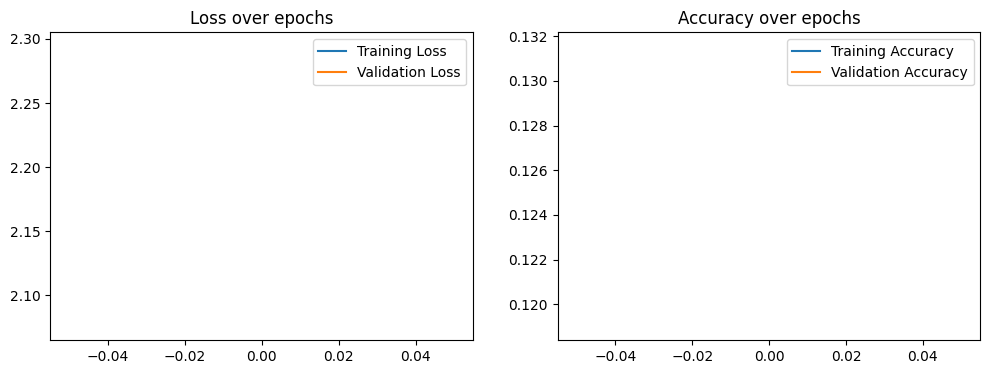


Epoch 1: val_accuracy improved from -inf to 0.12528, saving model to best_model.h5


ValueError: math domain error

In [33]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLearning(Callback):
    def on_train_begin(self, logs=None):
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))

        clear_output(wait=True)
        plt.figure(figsize=(12,4))

        plt.subplot(1,2,1)
        plt.plot(self.losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.title('Loss over epochs')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(self.accuracies, label='Training Accuracy')
        plt.plot(self.val_accuracies, label='Validation Accuracy')
        plt.title('Accuracy over epochs')
        plt.legend()

        plt.show()

# Calculate dataset cardinalities (number of batches)
train_batches = tf.data.experimental.cardinality(train_dataset).numpy()
val_batches = tf.data.experimental.cardinality(val_dataset).numpy()

print(f"Train batches per epoch: {train_batches}")
print(f"Validation batches per epoch: {val_batches}")

# Define any other callbacks you want, e.g. ModelCheckpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=train_batches,        # must specify for progress bar
    validation_steps=val_batches,          # must specify for progress bar
    verbose=1,
    callbacks=[PlotLearning(), checkpoint]
)


# New Section